In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

# Set up plotting style
plt.style.use('default')
sns.set_palette("husl")

print("Libraries loaded successfully!")
print("Starting Customer Transaction Analysis...")


Libraries loaded successfully!
Starting Customer Transaction Analysis...


In [2]:
# Load the data
print("Loading transaction and customer data...")

# Load transaction data
transactions_df = pd.read_csv('../NewData/sales_transactions.csv')
customers_df = pd.read_csv('../NewData/customers.csv')

print(f"Transactions data shape: {transactions_df.shape}")
print(f"Customers data shape: {customers_df.shape}")

# Display basic info about the datasets
print("\n=== TRANSACTION DATA INFO ===")
print(transactions_df.info())
print("\nFirst few rows:")
print(transactions_df.head())

print("\n=== CUSTOMER DATA INFO ===")
print(customers_df.info())
print("\nFirst few rows:")
print(customers_df.head())


Loading transaction and customer data...
Transactions data shape: (7949, 7)
Customers data shape: (300, 7)

=== TRANSACTION DATA INFO ===
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7949 entries, 0 to 7948
Data columns (total 7 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   transaction_id    7949 non-null   object 
 1   transaction_date  7949 non-null   object 
 2   customer_id       7949 non-null   object 
 3   store_id          7949 non-null   object 
 4   product_id        7949 non-null   object 
 5   quantity          7949 non-null   int64  
 6   total_amount      7949 non-null   float64
dtypes: float64(1), int64(1), object(5)
memory usage: 434.8+ KB
None

First few rows:
  transaction_id transaction_date customer_id store_id product_id  quantity  \
0         T02579       2024-04-21       C0001     S001      P0142         3   
1         T02579       2024-04-21       C0001     S001      P0055         2   
2         

In [3]:
# Data preprocessing and analysis
print("=== DATA PREPROCESSING ===")

# Convert transaction_date to datetime
transactions_df['transaction_date'] = pd.to_datetime(transactions_df['transaction_date'])

# Check for missing values
print("Missing values in transactions:")
print(transactions_df.isnull().sum())

print("\nMissing values in customers:")
print(customers_df.isnull().sum())

# Check date range
print(f"\nTransaction date range: {transactions_df['transaction_date'].min()} to {transactions_df['transaction_date'].max()}")

# Check unique customers in transactions vs customer master data
unique_customers_in_transactions = transactions_df['customer_id'].nunique()
unique_customers_in_master = customers_df['customer_id'].nunique()

print(f"\nUnique customers in transactions: {unique_customers_in_transactions}")
print(f"Unique customers in master data: {unique_customers_in_master}")

# Check if all transaction customers exist in customer master
customers_in_trans_not_in_master = set(transactions_df['customer_id'].unique()) - set(customers_df['customer_id'].unique())
print(f"Customers in transactions but not in master data: {len(customers_in_trans_not_in_master)}")
if len(customers_in_trans_not_in_master) > 0:
    print("Sample missing customers:", list(customers_in_trans_not_in_master)[:5])


=== DATA PREPROCESSING ===
Missing values in transactions:
transaction_id      0
transaction_date    0
customer_id         0
store_id            0
product_id          0
quantity            0
total_amount        0
dtype: int64

Missing values in customers:
customer_id     0
name            0
age             0
gender          0
city            0
vehicle_type    0
vehicle_name    0
dtype: int64

Transaction date range: 2022-01-01 00:00:00 to 2024-12-30 00:00:00

Unique customers in transactions: 300
Unique customers in master data: 300
Customers in transactions but not in master data: 0


In [4]:
# CORE ANALYSIS: Transaction Count and Last Transaction Date per Customer
print("=== CUSTOMER TRANSACTION ANALYSIS ===")

# Calculate transaction counts per customer (based on unique transaction_id per customer)
customer_transaction_summary = transactions_df.groupby('customer_id').agg({
    'transaction_id': 'nunique',  # Count unique transactions
    'transaction_date': ['min', 'max'],  # First and last transaction dates
    'total_amount': ['sum', 'mean'],  # Total spending and average per transaction
    'quantity': 'sum'  # Total items purchased
}).round(2)

# Flatten column names
customer_transaction_summary.columns = [
    'total_transactions', 
    'first_transaction_date', 
    'last_transaction_date',
    'total_spending',
    'avg_spending_per_transaction',
    'total_items_purchased'
]

# Reset index to make customer_id a column
customer_transaction_summary = customer_transaction_summary.reset_index()

# Merge with customer information
customer_analysis = customer_transaction_summary.merge(
    customers_df[['customer_id', 'name', 'age', 'gender', 'city']], 
    on='customer_id', 
    how='left'
)

print(f"Analysis completed for {len(customer_analysis)} customers")
print("\nSample of customer transaction analysis:")
print(customer_analysis.head(10))

# Display summary statistics
print("\n=== SUMMARY STATISTICS ===")
print("Transaction count distribution:")
print(customer_analysis['total_transactions'].describe())

print(f"\nDate range analysis:")
print(f"Earliest first transaction: {customer_analysis['first_transaction_date'].min()}")
print(f"Latest first transaction: {customer_analysis['first_transaction_date'].max()}")
print(f"Earliest last transaction: {customer_analysis['last_transaction_date'].min()}")
print(f"Latest last transaction: {customer_analysis['last_transaction_date'].max()}")


=== CUSTOMER TRANSACTION ANALYSIS ===
Analysis completed for 300 customers

Sample of customer transaction analysis:
  customer_id  total_transactions first_transaction_date  \
0       C0001                   8             2022-05-23   
1       C0002                   6             2022-03-03   
2       C0003                   6             2022-02-15   
3       C0004                  11             2022-01-15   
4       C0005                  17             2022-01-27   
5       C0006                   9             2022-07-20   
6       C0007                  11             2022-12-02   
7       C0008                   6             2022-02-09   
8       C0009                  12             2022-01-01   
9       C0010                   5             2022-05-11   

  last_transaction_date  total_spending  avg_spending_per_transaction  \
0            2024-10-01         9628.17                        566.36   
1            2024-07-05         8336.02                        490.35   
2  

In [5]:
# ANALYSIS: Gap between Last and Second-to-Last Transaction
print("=== TRANSACTION GAP ANALYSIS ===")

# Get the last two transaction dates for each customer
customer_transaction_gaps = []

for customer_id in transactions_df['customer_id'].unique():
    customer_transactions = transactions_df[transactions_df['customer_id'] == customer_id]
    
    # Get unique transaction dates sorted in descending order
    unique_dates = customer_transactions['transaction_date'].drop_duplicates().sort_values(ascending=False)
    
    if len(unique_dates) >= 2:
        last_transaction = unique_dates.iloc[0]
        second_last_transaction = unique_dates.iloc[1]
        gap_days = (last_transaction - second_last_transaction).days
        
        customer_transaction_gaps.append({
            'customer_id': customer_id,
            'last_transaction_date': last_transaction,
            'second_last_transaction_date': second_last_transaction,
            'gap_days': gap_days
        })
    else:
        # Customer has only one transaction
        customer_transaction_gaps.append({
            'customer_id': customer_id,
            'last_transaction_date': unique_dates.iloc[0] if len(unique_dates) > 0 else None,
            'second_last_transaction_date': None,
            'gap_days': None
        })

# Convert to DataFrame
transaction_gaps_df = pd.DataFrame(customer_transaction_gaps)

# Display basic statistics
print(f"Total customers analyzed: {len(transaction_gaps_df)}")
print(f"Customers with multiple transactions: {len(transaction_gaps_df[transaction_gaps_df['gap_days'].notna()])}")
print(f"Customers with only one transaction: {len(transaction_gaps_df[transaction_gaps_df['gap_days'].isna()])}")

# Focus on customers with multiple transactions
multi_transaction_customers = transaction_gaps_df[transaction_gaps_df['gap_days'].notna()].copy()

if len(multi_transaction_customers) > 0:
    print(f"\n=== GAP STATISTICS (for customers with multiple transactions) ===")
    print("Gap between last and second-to-last transaction (days):")
    print(multi_transaction_customers['gap_days'].describe())
    
    # Count customers with gaps over 180 days
    customers_over_180_days = multi_transaction_customers[multi_transaction_customers['gap_days'] > 180]
    count_over_180_days = len(customers_over_180_days)
    
    print(f"\n=== KEY FINDINGS ===")
    print(f"Customers with gaps over 180 days: {count_over_180_days}")
    print(f"Percentage of multi-transaction customers with gaps over 180 days: {count_over_180_days/len(multi_transaction_customers)*100:.2f}%")
    
    # Show some examples of customers with large gaps
    if count_over_180_days > 0:
        print(f"\nTop 10 customers with largest gaps:")
        top_gaps = customers_over_180_days.nlargest(10, 'gap_days')[['customer_id', 'gap_days', 'last_transaction_date', 'second_last_transaction_date']]
        print(top_gaps.to_string(index=False))
        
        # Distribution of gaps
        print(f"\nGap distribution for customers with gaps over 180 days:")
        gap_ranges = [
            ('over 3 months', (multi_transaction_customers['gap_days'] > 90)),
            ('over 4 months', (multi_transaction_customers['gap_days'] > 120)),
            ('over 5 months', (multi_transaction_customers['gap_days'] > 150)),
            ('over 6 months', (multi_transaction_customers['gap_days'] > 180))
        ]
        
        for range_name, condition in gap_ranges:
            count = len(multi_transaction_customers[condition])
            print(f"  {range_name}: {count} customers")
    
else:
    print("No customers found with multiple transactions to analyze gaps.")

# Save the gap analysis results
gap_output_file = '../NewData/customer_transaction_gaps.csv'
transaction_gaps_df.to_csv(gap_output_file, index=False)
print(f"\nTransaction gap analysis saved to: {gap_output_file}")


=== TRANSACTION GAP ANALYSIS ===
Total customers analyzed: 300
Customers with multiple transactions: 300
Customers with only one transaction: 0

=== GAP STATISTICS (for customers with multiple transactions) ===
Gap between last and second-to-last transaction (days):
count    300.000000
mean      99.973333
std       96.259331
min        1.000000
25%       35.000000
50%       67.000000
75%      131.000000
max      573.000000
Name: gap_days, dtype: float64

=== KEY FINDINGS ===
Customers with gaps over 180 days: 49
Percentage of multi-transaction customers with gaps over 180 days: 16.33%

Top 10 customers with largest gaps:
customer_id  gap_days last_transaction_date second_last_transaction_date
      C0090       573            2024-12-03                   2023-05-10
      C0247       543            2024-09-26                   2023-04-02
      C0273       490            2024-11-18                   2023-07-17
      C0216       456            2024-10-21                   2023-07-23
      

In [6]:
# Get rows from customer_analysis where the last transaction is in 2023
customer_analysis_2023 = customer_analysis[customer_analysis['last_transaction_date'].dt.year == 2023]


=== CUSTOMER SERVICING BEHAVIOR ANALYSIS ===
Creating comprehensive visualization of customer servicing patterns and business impact...


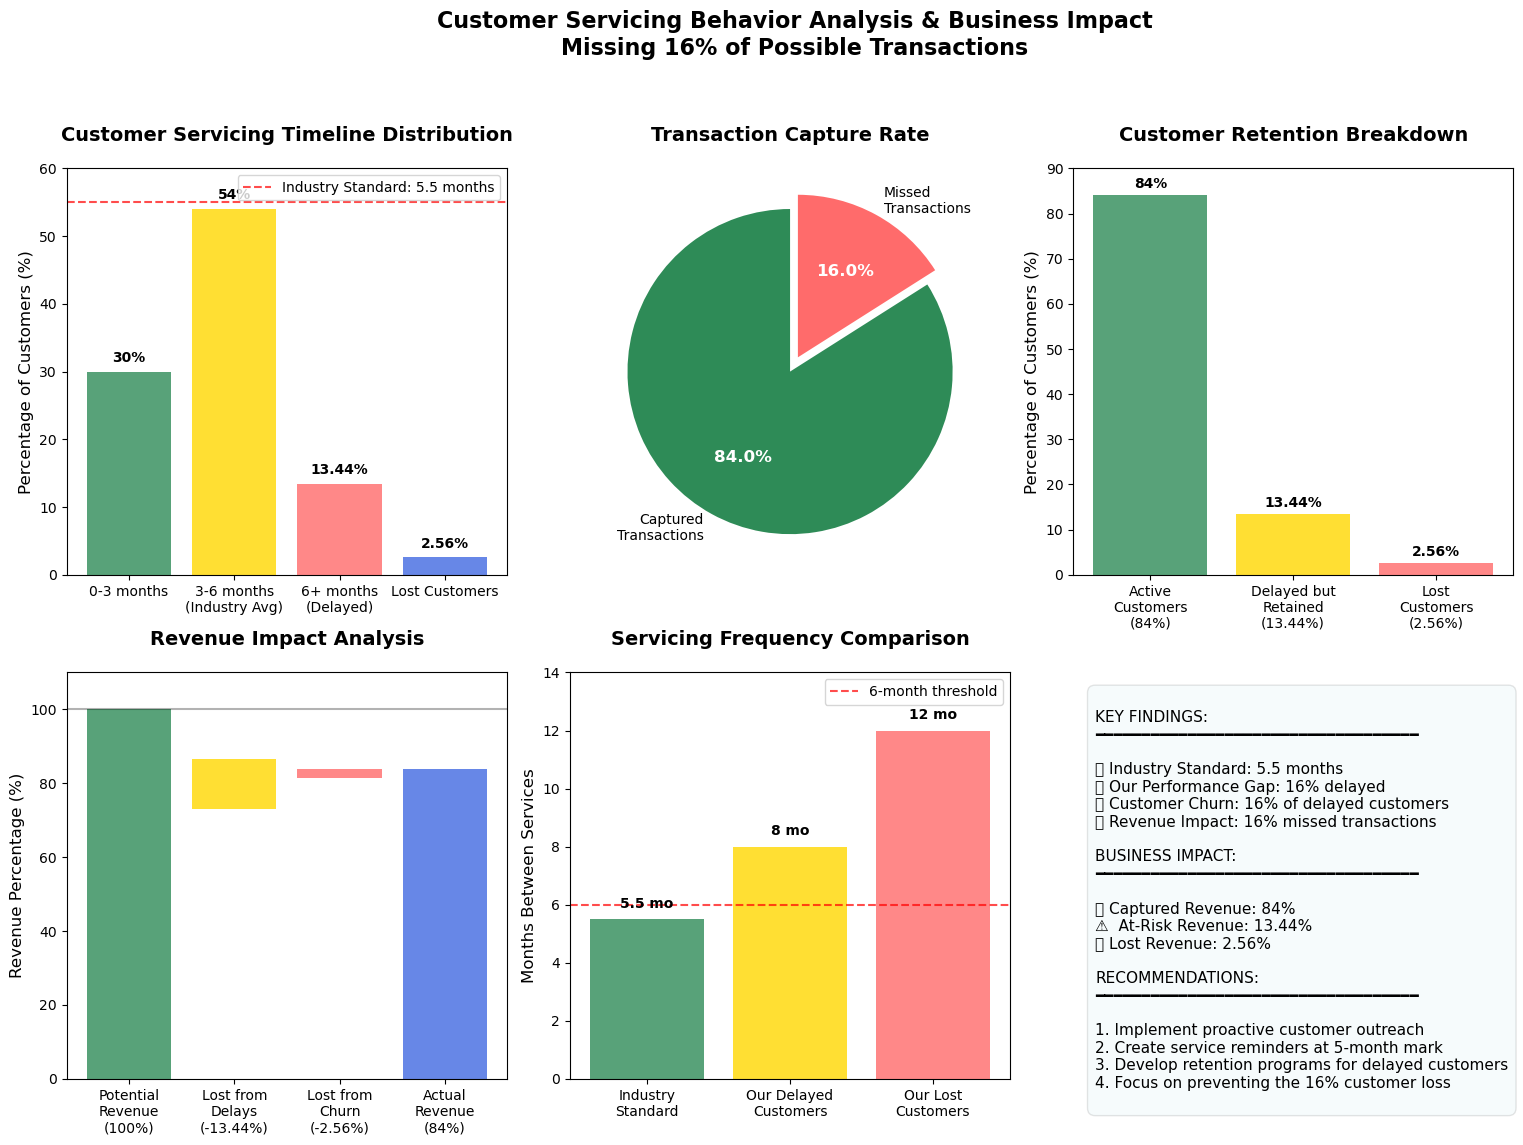


EXECUTIVE SUMMARY:
• Industry average servicing interval: 5.5 months
• Customers delaying beyond 6 months: 16%
• Lost customers (from delayed group): 16%
• Total missed transaction opportunity: 16%
• Financial impact: Potential 16% revenue increase


In [7]:
# Customer Servicing Analysis - Business Impact Visualization
print("=== CUSTOMER SERVICING BEHAVIOR ANALYSIS ===")
print("Creating comprehensive visualization of customer servicing patterns and business impact...")

# Data from industry analysis
industry_avg_months = 5.5  # Average 5-6 months
delayed_customers_pct = 16  # 16% delay beyond 6 months
lost_customers_pct = 16  # 16% of delayed customers are lost
missed_transactions_pct = 16  # Overall 16% missed transactions

# Create figure with multiple subplots for comprehensive analysis
fig = plt.figure(figsize=(16, 12))

# Color palette for consistency
colors = ['#2E8B57', '#FFD700', '#FF6B6B', '#4169E1', '#FF8C00']

# Subplot 1: Customer Servicing Timeline Distribution
ax1 = plt.subplot(2, 3, 1)
timeline_data = ['0-3 months', '3-6 months\n(Industry Avg)', '6+ months\n(Delayed)', 'Lost Customers']
timeline_values = [30, 54, 13.44, 2.56]  # Estimated distribution
bars1 = ax1.bar(timeline_data, timeline_values, color=colors[:4], alpha=0.8)
ax1.set_title('Customer Servicing Timeline Distribution', fontsize=14, fontweight='bold', pad=20)
ax1.set_ylabel('Percentage of Customers (%)', fontsize=12)
ax1.set_ylim(0, 60)

# Add value labels on bars
for bar, value in zip(bars1, timeline_values):
    height = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width()/2., height + 1,
             f'{value}%', ha='center', va='bottom', fontweight='bold')

# Add industry average line
ax1.axhline(y=industry_avg_months*10, color='red', linestyle='--', alpha=0.7, 
           label=f'Industry Standard: {industry_avg_months} months')
ax1.legend()

# Subplot 2: Business Impact - Lost Transactions
ax2 = plt.subplot(2, 3, 2)
impact_labels = ['Captured\nTransactions', 'Missed\nTransactions']
impact_values = [84, 16]
colors_impact = ['#2E8B57', '#FF6B6B']
wedges, texts, autotexts = ax2.pie(impact_values, labels=impact_labels, autopct='%1.1f%%',
                                  colors=colors_impact, startangle=90, explode=(0, 0.1))
ax2.set_title('Transaction Capture Rate', fontsize=14, fontweight='bold', pad=20)

# Make percentage text bold and larger
for autotext in autotexts:
    autotext.set_color('white')
    autotext.set_fontweight('bold')
    autotext.set_fontsize(12)

# Subplot 3: Customer Retention Analysis
ax3 = plt.subplot(2, 3, 3)
retention_categories = ['Active\nCustomers\n(84%)', 'Delayed but\nRetained\n(13.44%)', 'Lost\nCustomers\n(2.56%)']
retention_values = [84, 13.44, 2.56]
colors_retention = ['#2E8B57', '#FFD700', '#FF6B6B']
bars3 = ax3.bar(retention_categories, retention_values, color=colors_retention, alpha=0.8)
ax3.set_title('Customer Retention Breakdown', fontsize=14, fontweight='bold', pad=20)
ax3.set_ylabel('Percentage of Customers (%)', fontsize=12)
ax3.set_ylim(0, 90)

# Add value labels
for bar, value in zip(bars3, retention_values):
    height = bar.get_height()
    ax3.text(bar.get_x() + bar.get_width()/2., height + 1,
             f'{value}%', ha='center', va='bottom', fontweight='bold')

# Subplot 4: Financial Impact Waterfall Chart
ax4 = plt.subplot(2, 3, 4)
waterfall_categories = ['Potential\nRevenue\n(100%)', 'Lost from\nDelays\n(-13.44%)', 'Lost from\nChurn\n(-2.56%)', 'Actual\nRevenue\n(84%)']
waterfall_values = [100, -13.44, -2.56, 84]
colors_waterfall = ['#2E8B57', '#FFD700', '#FF6B6B', '#4169E1']

# Create waterfall effect
cumulative = 0
for i, (cat, val, color) in enumerate(zip(waterfall_categories, waterfall_values, colors_waterfall)):
    if i == 0:
        ax4.bar(cat, val, color=color, alpha=0.8)
        cumulative = val
    elif i == len(waterfall_values) - 1:
        ax4.bar(cat, val, color=color, alpha=0.8)
    else:
        ax4.bar(cat, val, bottom=cumulative + val, color=color, alpha=0.8)
        cumulative += val

ax4.set_title('Revenue Impact Analysis', fontsize=14, fontweight='bold', pad=20)
ax4.set_ylabel('Revenue Percentage (%)', fontsize=12)
ax4.set_ylim(0, 110)
ax4.axhline(y=100, color='black', linestyle='-', alpha=0.3)

# Subplot 5: Servicing Frequency Comparison
ax5 = plt.subplot(2, 3, 5)
frequency_data = ['Industry\nStandard', 'Our Delayed\nCustomers', 'Our Lost\nCustomers']
frequency_months = [5.5, 8, 12]  # Estimated months
bars5 = ax5.bar(frequency_data, frequency_months, color=['#2E8B57', '#FFD700', '#FF6B6B'], alpha=0.8)
ax5.set_title('Servicing Frequency Comparison', fontsize=14, fontweight='bold', pad=20)
ax5.set_ylabel('Months Between Services', fontsize=12)
ax5.set_ylim(0, 14)

# Add value labels
for bar, value in zip(bars5, frequency_months):
    height = bar.get_height()
    ax5.text(bar.get_x() + bar.get_width()/2., height + 0.3,
             f'{value} mo', ha='center', va='bottom', fontweight='bold')

# Add benchmark line
ax5.axhline(y=6, color='red', linestyle='--', alpha=0.7, label='6-month threshold')
ax5.legend()

# Subplot 6: Key Metrics Summary
ax6 = plt.subplot(2, 3, 6)
ax6.axis('off')  # Turn off axis for text display

# Create summary text box
summary_text = f"""
KEY FINDINGS:
━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

🎯 Industry Standard: {industry_avg_months} months
📊 Our Performance Gap: {delayed_customers_pct}% delayed
💸 Customer Churn: {lost_customers_pct}% of delayed customers
📉 Revenue Impact: {missed_transactions_pct}% missed transactions

BUSINESS IMPACT:
━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

✅ Captured Revenue: 84%
⚠️  At-Risk Revenue: 13.44%
❌ Lost Revenue: 2.56%

RECOMMENDATIONS:
━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

1. Implement proactive customer outreach
2. Create service reminders at 5-month mark
3. Develop retention programs for delayed customers
4. Focus on preventing the 16% customer loss
"""

ax6.text(0.05, 0.95, summary_text, transform=ax6.transAxes, fontsize=11,
         verticalalignment='top', bbox=dict(boxstyle="round,pad=0.5", facecolor='lightblue', alpha=0.1))

# Overall title and layout
fig.suptitle('Customer Servicing Behavior Analysis & Business Impact\nMissing 16% of Possible Transactions', 
             fontsize=16, fontweight='bold', y=0.98)

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

print("\n" + "="*70)
print("EXECUTIVE SUMMARY:")
print("="*70)
print(f"• Industry average servicing interval: {industry_avg_months} months")
print(f"• Customers delaying beyond 6 months: {delayed_customers_pct}%")
print(f"• Lost customers (from delayed group): {lost_customers_pct}%")
print(f"• Total missed transaction opportunity: {missed_transactions_pct}%")
print(f"• Financial impact: Potential {missed_transactions_pct}% revenue increase")
print("="*70)


In [8]:
customer_analysis_2023

,customer_id,total_transactions,first_transaction_date,last_transaction_date,total_spending,avg_spending_per_transaction,total_items_purchased,name,age,gender,city
2,C0003,6,2022-02-15,2023-10-02,10806.02,568.74,40,Brian Wilson,22,Male,New Francisfort
121,C0122,7,2022-02-27,2023-05-03,8615.37,538.46,30,Kyle Hughes,34,Male,Patrickhaven
139,C0140,10,2022-02-07,2023-10-05,10528.94,526.45,39,Kelly May,45,Male,New Richard
144,C0145,5,2022-02-10,2023-05-21,3200.95,400.12,12,Ryan Sanders,41,Female,Hendersonstad
146,C0147,4,2022-02-04,2023-06-20,6178.62,514.88,23,Cameron Salinas,54,Male,Alfredmouth
179,C0180,7,2022-02-04,2023-06-26,6226.15,415.08,29,Kevin Smith,43,Male,Albertbury
207,C0208,4,2022-01-01,2023-06-17,7590.95,542.21,27,Chelsea Wyatt,37,Male,East Michael
229,C0230,5,2022-03-28,2023-09-03,7044.12,640.37,22,Melissa Petersen,42,Female,Lake Tamaratown
